### CS Info

There has been lots of talking about diversity in the workplace, especially in technology. The Head of HR at your company is very concerned about that and has asked you to analyze internal data about employees and see whether results suggest that the company is treating all its employees fairly or not.
Specifically, she gave you the following tasks:
In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.
Individual Contributors(IC) - they don’t manage anyone
Middle Managers(MM) - they are the direct bosses of IC
Directors(D) - they are the direct bosses of MM
VP - D direct bosses
Executives (E) - VP direct bosses
CEO - The direct boss of E.
How many people each employee manages? Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.
Build a model to predict the salary of each employee.
Describe the main factors impacting employee salaries. Do you think the company has been treating all its employees fairly? What are the next steps you would suggest to the Head of HR?

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

%matplotlib inline 

In [68]:
employee = pd.read_csv('../diversity/employee.csv')
company = pd.read_csv('../diversity/company_hierarchy.csv')

In [69]:
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   employee_id     10000 non-null  int64  
 1   signing_bonus   10000 non-null  int64  
 2   salary          10000 non-null  float64
 3   degree_level    10000 non-null  object 
 4   sex             10000 non-null  object 
 5   yrs_experience  10000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 468.9+ KB


In [70]:
merged = pd.merge(employee, company, how='inner', on=['employee_id'])

In [71]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   employee_id     10000 non-null  int64  
 1   signing_bonus   10000 non-null  int64  
 2   salary          10000 non-null  float64
 3   degree_level    10000 non-null  object 
 4   sex             10000 non-null  object 
 5   yrs_experience  10000 non-null  int64  
 6   boss_id         9999 non-null   float64
 7   dept            10000 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 703.1+ KB


In [72]:
#Making a Manager Column
merged['boss_id'].fillna(100000, inplace=True)
merged['boss_id'] = merged['boss_id'].astype(int)


boss = set(merged.boss_id)
merged['is_manager'] = merged['employee_id'].apply(lambda x: x in boss).astype(int)


In [73]:
#Making a Direct Reports Column
reports = (merged['boss_id'].value_counts())
reports_df = pd.DataFrame(reports)

merged = pd.merge(merged, reports, how='left', left_on=['employee_id'], right_on=reports.index)
merged['boss_id_y'].fillna(0, inplace=True)
merged['direct_reports'] = merged['boss_id_y']
merged['boss_id'] = merged['boss_id_x']

merged.drop(labels=['boss_id_y', 'boss_id_x'], axis=1, inplace=True)

In [74]:
#Set Index to Employee Id
merged.set_index(keys='employee_id', inplace=True)

In [75]:
##Total Reports

In [76]:
from collections import defaultdict
emp_list = list(merged['boss_id'].index)
boss_list = list(merged['boss_id'].values)

In [77]:
d_reports= defaultdict(list)
for boss,employee in zip(boss_list,emp_list):
    d_reports[boss].append(employee)

my_boss = defaultdict()
for boss,employee in zip(boss_list,emp_list):
    my_boss[employee] = boss    

In [78]:
total_reports = {}
for emp in emp_list:
    total_reports[emp] = 0

In [79]:
ceo_id = 61554

for emp in my_boss:
    if emp == ceo_id:
        continue 
    while True:
        boss = my_boss[emp]
        if boss != ceo_id:
            total_reports[boss] += 1
        elif boss == ceo_id:
            break 
        emp = boss     

In [80]:
total_reports = pd.Series(total_reports)

In [81]:
merged['total_reports'] = total_reports

In [82]:
merged.loc[ceo_id, 'total_reports'] = 9999

In [83]:
#Company Level 

In [84]:
company_level = {}
for emp in emp_list:
    company_level[emp] = 0

In [85]:
for emp in my_boss:
    counter = 0 
    if emp == ceo_id:
        continue 
    while True:
        boss = my_boss[emp]
        if boss != ceo_id:
            counter += 1 
        elif boss == ceo_id:
            break  
        emp = boss    
        company_level[emp] = counter

In [86]:
company_level = pd.Series(company_level)

In [87]:
merged['company_level'] = company_level

In [88]:
#Save CSV 
merged.to_csv('../company_x.csv')

In [89]:
merged.head()

,signing_bonus,salary,degree_level,sex,yrs_experience,dept,is_manager,direct_reports,boss_id,total_reports,company_level
employee_id,,,,,,,,,,,
138719,0,273000.0,Master,M,2,engineering,0,0.0,43602,0,0
3192,0,301000.0,Bachelor,F,1,sales,0,0.0,87847,0,0
114657,0,261000.0,Master,F,2,sales,0,0.0,180854,0,0
29039,0,86000.0,High_School,F,4,HR,0,0.0,88370,0,0
118607,0,126000.0,Bachelor,F,3,sales,0,0.0,23565,0,0


In [90]:
# aeq_data = merged.copy()
# aeq_data = aeq_data.drop(labels=['boss_id, )

## EDA 

In [91]:
(merged['sex'].value_counts() / 10000).round(2)

M    0.64
F    0.36
Name: sex, dtype: float64

Text(0.5, 1.0, 'Employee Salaries')

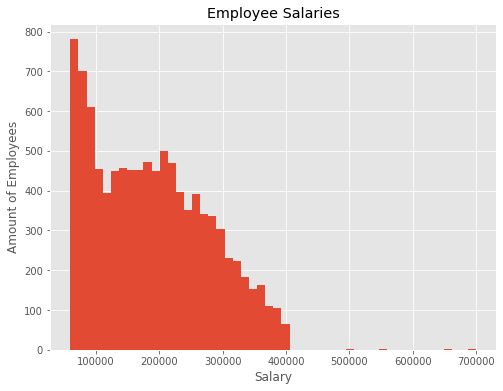

In [92]:
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(merged['salary'], bins=50)
ax.set_xlabel('Salary')
ax.set_ylabel('Amount of Employees')
ax.set_title('Employee Salaries')

In [93]:
man = merged[merged['sex']=='M']
woman = mans = merged[merged['sex']=='F']

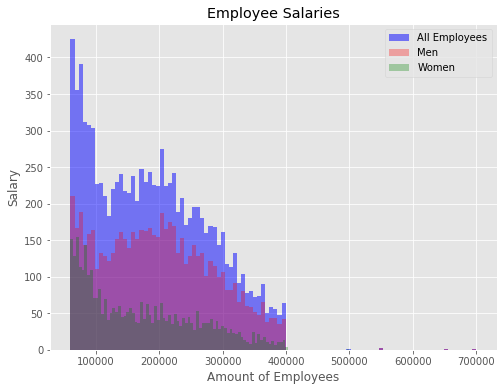

In [94]:
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(merged['salary'], bins=100, label='All Employees', alpha=.5, color='blue')
ax.hist(man['salary'], bins=100, alpha=.3, label='Men', color='red')
ax.hist(woman['salary'], bins=100, alpha=.3, label='Women', color='green')
ax.set_xlabel('Amount of Employees')
ax.set_ylabel('Salary')
ax.set_title('Employee Salaries')
ax.legend()
plt.savefig('images/salaries')

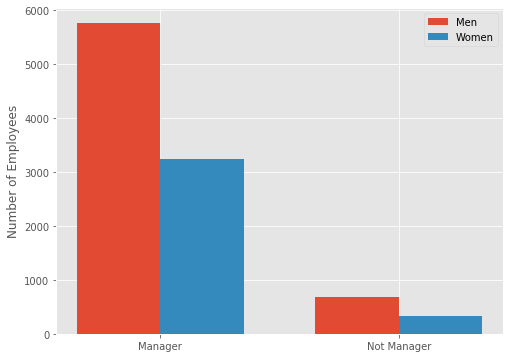

In [95]:
fig, ax = plt.subplots(figsize=(8,6))


ind = np.arange(2)
width = 0.35

ax.bar(ind-width/2, man['is_manager'].value_counts(), width, label='Men')
ax.bar(ind+width/2, woman['is_manager'].value_counts(), width, label='Women')
ax.set_ylabel('Number of Employees')
ax.set_xticks(ind)
ax.set_xticklabels(['Manager', 'Not Manager'])
ax.legend()

In [96]:
man['is_manager'].sum() / len(man['is_manager'])

0.10529585339338407

In [97]:
woman['is_manager'].sum() / len(woman['is_manager'])

0.09014321819713564

In [98]:
merged[['company_level', 'sex']].groupby(['company_level'])['sex'].value_counts()

company_level  sex
0              M      5762
               F      3240
1              M       546
               F       266
2              M       102
               F        46
3              M        26
               F         8
4              M         3
               F         1
Name: sex, dtype: int64

In [99]:
merged[['degree_level', 'sex']].groupby(['degree_level'])['sex'].value_counts()

degree_level  sex
Bachelor      M      1758
              F       977
High_School   M      1083
              F       574
Master        M      1785
              F      1001
PhD           M      1813
              F      1009
Name: sex, dtype: int64

In [100]:
salary_table = pd.DataFrame(merged[['dept', 'sex', 'salary']].groupby(['dept', 'sex']).describe().round())

In [101]:
salary_table

salary                                                   \
                  count      mean      std       min       25%       50%   
dept        sex                                                            
CEO         M       1.0  700000.0      NaN  700000.0  700000.0  700000.0   
HR          F    1058.0   84400.0  22963.0   60000.0   69000.0   80000.0   
            M     636.0   84827.0  25967.0   60000.0   68000.0   79000.0   
engineering F     671.0  246785.0  88771.0   61000.0  177500.0  253000.0   
            M    2025.0  242444.0  87174.0   60000.0  175000.0  246000.0   
marketing   F     651.0  192502.0  74874.0   60000.0  135000.0  184000.0   
            M    1359.0  195639.0  76505.0   60000.0  136500.0  192000.0   
sales       F    1181.0  194618.0  72070.0   60000.0  139000.0  190000.0   
            M    2418.0  194207.0  72926.0   60000.0  140000.0  190000.0   

                                     
                      75%       max  
dept        sex                      
CEO         M    700000.0  700000.0  
HR          F     94000.0  500000.0  
            M     93000.0  361000.0  
engineering F    317000.0  399000.0  
            M    312000.0  650000.0  
marketing   F    252500.0  399000.0  
            M    248000.0  550000.0  
sales       F    245000.0  398000.0  
            M    244000.0  550000.0

In [102]:
merged[['dept', 'sex', 'yrs_experience']].groupby(['dept', 'sex']).describe().round()

yrs_experience                                    
                         count mean  std  min  25%  50%  75%   max
dept        sex                                                   
CEO         M              1.0  7.0  NaN  7.0  7.0  7.0  7.0   7.0
HR          F           1058.0  4.0  3.0  1.0  2.0  3.0  5.0  28.0
            M            636.0  4.0  3.0  1.0  2.0  3.0  5.0  30.0
engineering F            671.0  4.0  3.0  1.0  2.0  3.0  5.0  33.0
            M           2025.0  4.0  3.0  1.0  2.0  3.0  5.0  33.0
marketing   F            651.0  4.0  4.0  1.0  2.0  3.0  5.0  24.0
            M           1359.0  4.0  3.0  1.0  2.0  3.0  5.0  33.0
sales       F           1181.0  4.0  3.0  1.0  2.0  3.0  5.0  34.0
            M           2418.0  4.0  3.0  1.0  2.0  3.0  5.0  32.0

In [103]:
merged[['dept', 'sex', 'company_level']].groupby(['dept', 'sex'])['company_level'].value_counts()

dept         sex  company_level
CEO          M    0                   1
HR           F    0                 972
                  1                  74
                  2                  10
                  3                   1
                  4                   1
             M    0                 553
                  1                  62
                  2                  16
                  3                   5
engineering  F    0                 605
                  1                  57
                  2                   7
                  3                   2
             M    0                1824
                  1                 160
                  2                  32
                  3                   8
                  4                   1
marketing    F    0                 588
                  1                  46
                  2                  15
                  3                   2
             M    0                1214
        

In [104]:
merged[['dept', 'sex', 'is_manager']].groupby(['dept', 'sex'])['is_manager'].value_counts()

dept         sex  is_manager
CEO          M    1                1
HR           F    0              972
                  1               86
             M    0              553
                  1               83
engineering  F    0              605
                  1               66
             M    0             1824
                  1              201
marketing    F    0              588
                  1               63
             M    0             1214
                  1              145
sales        F    0             1075
                  1              106
             M    0             2170
                  1              248
Name: is_manager, dtype: int64

Men are overrepresented in management HR.  

In [105]:
merged[['sex', 'signing_bonus']].groupby(['sex'])['signing_bonus'].value_counts()

sex  signing_bonus
F    0                2594
     1                 967
M    0                4392
     1                2047
Name: signing_bonus, dtype: int64

In [106]:
967/2594

0.3727833461835004

In [107]:
2047/4392

0.4660746812386157

In [108]:
merged[['dept', 'signing_bonus']].groupby(['dept'])['signing_bonus'].value_counts()

dept         signing_bonus
CEO          1                   1
HR           0                1473
             1                 221
engineering  0                1643
             1                1053
marketing    0                1387
             1                 623
sales        0                2483
             1                1116
Name: signing_bonus, dtype: int64

In [109]:
1053/(1643+1053)

0.3905786350148368

In [110]:
623/(1387+623)

0.3099502487562189

Clearly HR is not getting the benefits of a signing bonus likethe other depts.  

## Signing Bonus with Bias! 

In [111]:
import scipy.stats as stats



In [112]:
stats.binom(1, .8).rvs()

1

In [113]:
stats.binom(1,.2).rvs()

1

In [114]:
def got_signing_bonus(x):
    if x == 'M':
        value =  stats.binom(1, .7).rvs()
    else:
        value = stats.binom(1,.5).rvs()
    return value
        

In [115]:
new_merged = merged.copy()

new_merged['new_signing_bonus'] = new_merged['sex'].transform(lambda x: (got_signing_bonus(x)))

In [116]:
merged.head()

,signing_bonus,salary,degree_level,sex,yrs_experience,dept,is_manager,direct_reports,boss_id,total_reports,company_level
employee_id,,,,,,,,,,,
138719,0,273000.0,Master,M,2,engineering,0,0.0,43602,0,0
3192,0,301000.0,Bachelor,F,1,sales,0,0.0,87847,0,0
114657,0,261000.0,Master,F,2,sales,0,0.0,180854,0,0
29039,0,86000.0,High_School,F,4,HR,0,0.0,88370,0,0
118607,0,126000.0,Bachelor,F,3,sales,0,0.0,23565,0,0


In [117]:

new_merged.drop(labels='signing_bonus', axis=1, inplace=True)

In [118]:
new_merged.head()

,salary,degree_level,sex,yrs_experience,dept,is_manager,direct_reports,boss_id,total_reports,company_level,new_signing_bonus
employee_id,,,,,,,,,,,
138719,273000.0,Master,M,2,engineering,0,0.0,43602,0,0,1
3192,301000.0,Bachelor,F,1,sales,0,0.0,87847,0,0,0
114657,261000.0,Master,F,2,sales,0,0.0,180854,0,0,0
29039,86000.0,High_School,F,4,HR,0,0.0,88370,0,0,1
118607,126000.0,Bachelor,F,3,sales,0,0.0,23565,0,0,0


In [119]:
new_merged.to_csv('../company_x_sb.csv')